# ETA Pipeline Demo

This notebook demonstrates the ETA-related functions in `ml/data/eta.py`:

1. **`filter_rows_after_stop`** - Remove rows after the last stop in each segment
2. **`add_eta`** - Calculate time until next stop arrival

These functions are used by `eta_pipeline()` in `ml/pipelines.py`.

In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import ETA functions
from ml.data.eta import filter_rows_after_stop, add_eta

print("ETA functions loaded successfully!")

2026-02-04 17:34:37 - ml - INFO - ML logging level: debug
ETA functions loaded successfully!


---
## 1. `filter_rows_after_stop`

Removes rows that occur after (and including) the last stop in each segment.

**Why?** Rows after the last stop have no "next stop" to calculate ETA to.

**Also removes:** Segments with no stops at all (since all rows would be "after the last stop").

### Function Signature
```python
def filter_rows_after_stop(
    df: pd.DataFrame,
    segment_column: str,
    stop_column: str
) -> pd.DataFrame:
```

**Returns a filtered DataFrame.**

In [2]:
# Create sample DataFrame with stops
df_filter = pd.DataFrame({
    'segment_id': [1, 1, 1, 1, 1, 1, 1],
    'stop_name': [
        None,         # Row 0: In transit
        'Stop A',     # Row 1: At Stop A
        None,         # Row 2: In transit
        None,         # Row 3: In transit
        'Stop B',     # Row 4: At Stop B (LAST STOP)
        None,         # Row 5: After last stop - WILL BE REMOVED
        None          # Row 6: After last stop - WILL BE REMOVED
    ],
    'epoch_seconds': [0, 10, 20, 30, 40, 50, 60],
    'value': ['a', 'b', 'c', 'd', 'e', 'f', 'g']
})

print("BEFORE filter_rows_after_stop:")
print(df_filter)
print(f"\nTotal rows: {len(df_filter)}")
print(f"Last stop at row 4 ('Stop B')")

BEFORE filter_rows_after_stop:
   segment_id stop_name  epoch_seconds value
0           1      None              0     a
1           1    Stop A             10     b
2           1      None             20     c
3           1      None             30     d
4           1    Stop B             40     e
5           1      None             50     f
6           1      None             60     g

Total rows: 7
Last stop at row 4 ('Stop B')


In [3]:
# Apply filter
df_filtered = filter_rows_after_stop(df_filter, 'segment_id', 'stop_name')

print("AFTER filter_rows_after_stop:")
print(df_filtered)
print(f"\nRows removed: {len(df_filter) - len(df_filtered)}")
print("→ Rows 5-6 removed (after last stop 'Stop B')")

AFTER filter_rows_after_stop:
   segment_id stop_name  epoch_seconds value
0           1      None              0     a
1           1    Stop A             10     b
2           1      None             20     c
3           1      None             30     d
4           1    Stop B             40     e

Rows removed: 2
→ Rows 5-6 removed (after last stop 'Stop B')


In [4]:
# Demonstrate segment filtering (segments with no stops)
df_no_stops = pd.DataFrame({
    'segment_id': [1, 1, 1, 2, 2, 2, 3, 3, 3],
    'stop_name': [
        None, 'Stop A', None,  # Segment 1: has stop
        None, None, None,       # Segment 2: NO stops - will be removed
        None, 'Stop B', None    # Segment 3: has stop
    ],
    'value': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
})

print("DataFrame with segment without stops:")
print(df_no_stops)
print(f"\nSegment 2 has no stops")

df_no_stops_filtered = filter_rows_after_stop(df_no_stops, 'segment_id', 'stop_name')
print("\nAFTER filter_rows_after_stop:")
print(df_no_stops_filtered)
print(f"\nSegments remaining: {df_no_stops_filtered['segment_id'].unique()}")
print("→ Segment 2 completely removed (no stops)")

DataFrame with segment without stops:
   segment_id stop_name value
0           1      None     a
1           1    Stop A     b
2           1      None     c
3           2      None     d
4           2      None     e
5           2      None     f
6           3      None     g
7           3    Stop B     h
8           3      None     i

Segment 2 has no stops

AFTER filter_rows_after_stop:
   segment_id stop_name value
0           1      None     a
1           1    Stop A     b
6           3      None     g
7           3    Stop B     h

Segments remaining: [1 3]
→ Segment 2 completely removed (no stops)


---
## 2. `add_eta`

Calculates ETA (Estimated Time of Arrival) to the next stop.

**Formula:** `ETA = next_stop_time - current_time`

**Groups by:** `vehicle_id` and `segment_id`

### Function Signature
```python
def add_eta(
    df: pd.DataFrame,
    stop_column: str,
    time_column: str,
    output_column: str
) -> pd.DataFrame:
```

**Returns a new DataFrame with ETA column.**

In [5]:
# Create sample DataFrame for ETA calculation
df_eta = pd.DataFrame({
    'vehicle_id': [1, 1, 1, 1, 1, 1],
    'segment_id': [1, 1, 1, 1, 1, 1],
    'stop_name': [
        None,         # t=0: In transit
        None,         # t=10: In transit
        'Stop A',     # t=20: At Stop A
        None,         # t=30: In transit
        None,         # t=40: In transit
        'Stop B'      # t=50: At Stop B
    ],
    'epoch_seconds': [0, 10, 20, 30, 40, 50]
})

print("BEFORE add_eta:")
print(df_eta)
print(f"\nStops at t=20 (Stop A) and t=50 (Stop B)")

BEFORE add_eta:
   vehicle_id  segment_id stop_name  epoch_seconds
0           1           1      None              0
1           1           1      None             10
2           1           1    Stop A             20
3           1           1      None             30
4           1           1      None             40
5           1           1    Stop B             50

Stops at t=20 (Stop A) and t=50 (Stop B)


In [6]:
# Apply add_eta
df_eta_result = add_eta(df_eta, 'stop_name', 'epoch_seconds', 'eta_seconds')

print("AFTER add_eta:")
print(df_eta_result)
print(f"\nNew column: 'eta_seconds'")

AFTER add_eta:
   vehicle_id  segment_id stop_name  epoch_seconds  eta_seconds
0           1           1      None              0         20.0
1           1           1      None             10         10.0
2           1           1    Stop A             20         30.0
3           1           1      None             30         20.0
4           1           1      None             40         10.0
5           1           1    Stop B             50          NaN

New column: 'eta_seconds'


/Users/joel/eclipse-workspace/shuttletracker-new/ml/data/eta.py:165: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_work = df_work.groupby(['vehicle_id', 'segment_id'], group_keys=False).apply(


In [7]:
# Interpret results
print("ETA Calculation Explanation:")
print("="*60)
for idx in range(len(df_eta_result)):
    row = df_eta_result.iloc[idx]
    t = row['epoch_seconds']
    eta = row['eta_seconds']
    stop = row['stop_name']

    if pd.notna(stop):
        status = f"AT STOP '{stop}'"
    else:
        status = "In transit"

    if pd.notna(eta):
        next_stop_time = t + eta
        print(f"Row {idx} (t={t:3.0f}): {status:20s} -> ETA={eta:.0f}s (arrives at t={next_stop_time:.0f})")
    else:
        print(f"Row {idx} (t={t:3.0f}): {status:20s} -> ETA=NaN (no next stop)")

ETA Calculation Explanation:
Row 0 (t=  0): In transit           -> ETA=20s (arrives at t=20)
Row 1 (t= 10): In transit           -> ETA=10s (arrives at t=20)
Row 2 (t= 20): AT STOP 'Stop A'     -> ETA=30s (arrives at t=50)
Row 3 (t= 30): In transit           -> ETA=20s (arrives at t=50)
Row 4 (t= 40): In transit           -> ETA=10s (arrives at t=50)
Row 5 (t= 50): AT STOP 'Stop B'     -> ETA=NaN (no next stop)


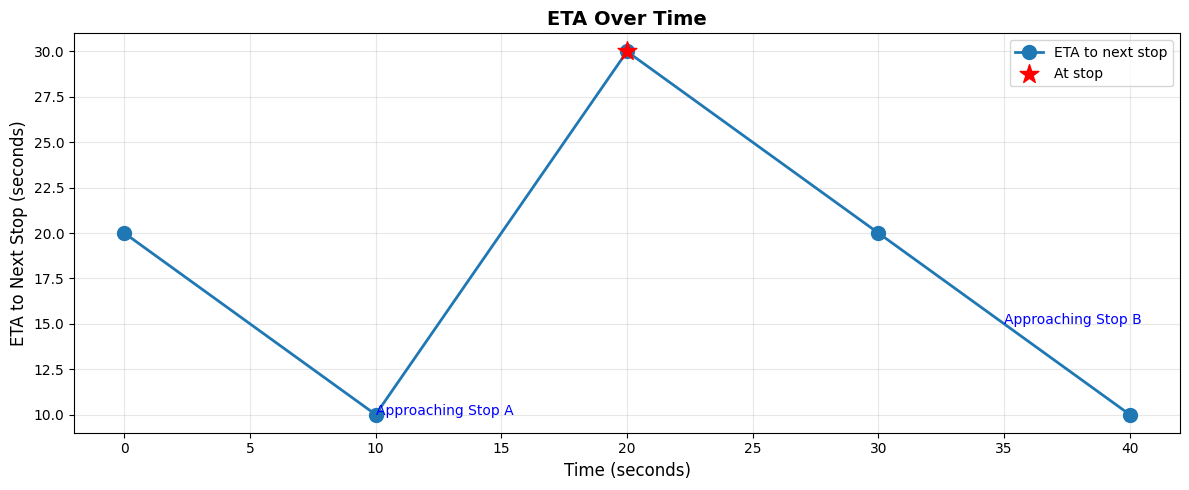

In [8]:
# Visualize ETA over time
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))

# Plot ETA
valid = df_eta_result['eta_seconds'].notna()
ax.plot(df_eta_result.loc[valid, 'epoch_seconds'],
        df_eta_result.loc[valid, 'eta_seconds'],
        marker='o', linewidth=2, markersize=10, label='ETA to next stop')

# Mark stops
stops = df_eta_result['stop_name'].notna()
ax.scatter(df_eta_result.loc[stops, 'epoch_seconds'],
          df_eta_result.loc[stops, 'eta_seconds'],
          color='red', s=200, marker='*', label='At stop', zorder=5)

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('ETA to Next Stop (seconds)', fontsize=12)
ax.set_title('ETA Over Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Add annotations
ax.annotate('Approaching Stop A', xy=(10, 10), fontsize=10, color='blue')
ax.annotate('Approaching Stop B', xy=(35, 15), fontsize=10, color='blue')

plt.tight_layout()
plt.show()

### Multiple Vehicles/Segments

In [9]:
# Demonstrate ETA with multiple vehicles
df_multi = pd.DataFrame({
    'vehicle_id': [1, 1, 1, 2, 2, 2],
    'segment_id': [1, 1, 1, 2, 2, 2],
    'stop_name': [
        None, 'Stop A', None,   # Vehicle 1
        None, None, 'Stop B'    # Vehicle 2
    ],
    'epoch_seconds': [0, 15, 30, 0, 10, 25]
})

print("Multiple vehicles:")
print(df_multi)

df_multi_result = add_eta(df_multi, 'stop_name', 'epoch_seconds', 'eta_seconds')
print("\nWith ETAs:")
print(df_multi_result)
print("\n→ Each vehicle/segment calculated independently")

Multiple vehicles:
   vehicle_id  segment_id stop_name  epoch_seconds
0           1           1      None              0
1           1           1    Stop A             15
2           1           1      None             30
3           2           2      None              0
4           2           2      None             10
5           2           2    Stop B             25

With ETAs:
   vehicle_id  segment_id stop_name  epoch_seconds  eta_seconds
0           1           1      None              0         15.0
1           1           1    Stop A             15          NaN
2           1           1      None             30          NaN
3           2           2      None              0         25.0
4           2           2      None             10         15.0
5           2           2    Stop B             25          NaN

→ Each vehicle/segment calculated independently


/Users/joel/eclipse-workspace/shuttletracker-new/ml/data/eta.py:165: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_work = df_work.groupby(['vehicle_id', 'segment_id'], group_keys=False).apply(


---
## Combined Example: Full ETA Pipeline

In [10]:
# Simulate a realistic trip segment
df_trip = pd.DataFrame({
    'vehicle_id': [1] * 12,
    'segment_id': [1] * 12,
    'stop_name': [
        None, None,           # Approaching first stop
        'Student Union',      # At stop
        None, None, None,     # In transit
        'West Hall',          # At stop
        None, None,           # In transit
        'City Station',       # At stop (LAST)
        None, None            # After last stop
    ],
    'epoch_seconds': [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165]
})

print("Original trip data:")
print(df_trip)
print(f"\nRows: {len(df_trip)}, Stops: {df_trip['stop_name'].notna().sum()}")

Original trip data:
    vehicle_id  segment_id      stop_name  epoch_seconds
0            1           1           None              0
1            1           1           None             15
2            1           1  Student Union             30
3            1           1           None             45
4            1           1           None             60
5            1           1           None             75
6            1           1      West Hall             90
7            1           1           None            105
8            1           1           None            120
9            1           1   City Station            135
10           1           1           None            150
11           1           1           None            165

Rows: 12, Stops: 3


In [11]:
# Step 1: Filter rows after last stop
df_filtered = filter_rows_after_stop(df_trip, 'segment_id', 'stop_name')
print("After filter_rows_after_stop:")
print(df_filtered)
print(f"\nRemoved {len(df_trip) - len(df_filtered)} rows after last stop")

After filter_rows_after_stop:
   vehicle_id  segment_id      stop_name  epoch_seconds
0           1           1           None              0
1           1           1           None             15
2           1           1  Student Union             30
3           1           1           None             45
4           1           1           None             60
5           1           1           None             75
6           1           1      West Hall             90
7           1           1           None            105
8           1           1           None            120
9           1           1   City Station            135

Removed 2 rows after last stop


In [12]:
# Step 2: Add ETAs
df_with_eta = add_eta(df_filtered, 'stop_name', 'epoch_seconds', 'eta_seconds')
print("After add_eta:")
print(df_with_eta)
print(f"\nETAs calculated: {df_with_eta['eta_seconds'].notna().sum()}/{len(df_with_eta)}")

After add_eta:
   vehicle_id  segment_id      stop_name  epoch_seconds  eta_seconds
0           1           1           None              0         30.0
1           1           1           None             15         15.0
2           1           1  Student Union             30         60.0
3           1           1           None             45         45.0
4           1           1           None             60         30.0
5           1           1           None             75         15.0
6           1           1      West Hall             90         45.0
7           1           1           None            105         30.0
8           1           1           None            120         15.0
9           1           1   City Station            135          NaN

ETAs calculated: 9/10


/Users/joel/eclipse-workspace/shuttletracker-new/ml/data/eta.py:165: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_work = df_work.groupby(['vehicle_id', 'segment_id'], group_keys=False).apply(


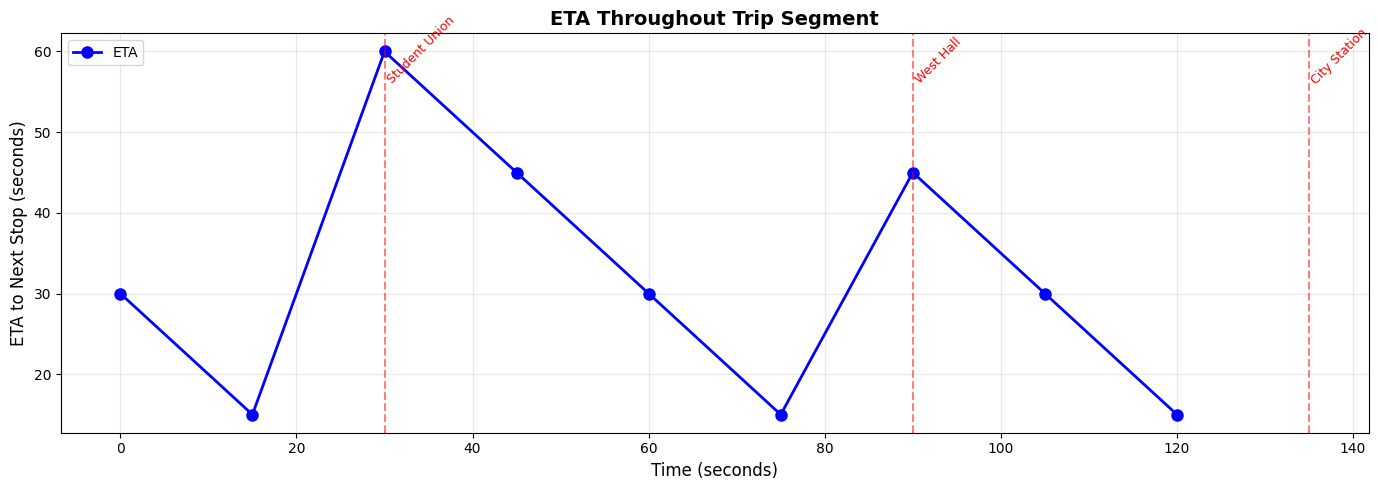

In [13]:
# Visualize the complete trip with ETAs
fig, ax = plt.subplots(figsize=(14, 5))

valid = df_with_eta['eta_seconds'].notna()
ax.plot(df_with_eta.loc[valid, 'epoch_seconds'],
        df_with_eta.loc[valid, 'eta_seconds'],
        marker='o', linewidth=2, markersize=8, color='blue', label='ETA')

# Mark stops
stops_mask = df_with_eta['stop_name'].notna()
for _, row in df_with_eta[stops_mask].iterrows():
    ax.axvline(x=row['epoch_seconds'], color='red', linestyle='--', alpha=0.5)
    ax.annotate(row['stop_name'],
               xy=(row['epoch_seconds'], ax.get_ylim()[1] * 0.9),
               rotation=45, fontsize=9, color='red')

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('ETA to Next Stop (seconds)', fontsize=12)
ax.set_title('ETA Throughout Trip Segment', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

---
## Integration with `eta_pipeline`

In `ml/pipelines.py`:

In [14]:
# Show how eta_pipeline uses these functions
print("""
def eta_pipeline(df: pd.DataFrame = None, **kwargs) -> pd.DataFrame:
    from ml.data.eta import filter_rows_after_stop, add_eta

    # Step 1: Get stops data
    if df is None:
        df = stops_pipeline(**kwargs)

    # Step 2: Filter rows after last stop
    # (also removes segments without any stops)
    df = filter_rows_after_stop(df, 'segment_id', 'stop_name')

    # Step 3: Add ETAs
    df = add_eta(df, 'stop_name', 'epoch_seconds', 'eta_seconds')

    return df
""")


def eta_pipeline(df: pd.DataFrame = None, **kwargs) -> pd.DataFrame:
    from ml.data.eta import filter_rows_after_stop, add_eta

    # Step 1: Get stops data
    if df is None:
        df = stops_pipeline(**kwargs)

    # Step 2: Filter rows after last stop
    # (also removes segments without any stops)
    df = filter_rows_after_stop(df, 'segment_id', 'stop_name')

    # Step 3: Add ETAs
    df = add_eta(df, 'stop_name', 'epoch_seconds', 'eta_seconds')

    return df



In [15]:
# Run the actual eta_pipeline on real data
from ml.pipelines import eta_pipeline

# Load ETA data (uses cache if available)
df = eta_pipeline()

print(f"Processed {len(df):,} records")
print(f"Segments: {df['segment_id'].nunique():,}")
print(f"\nETA statistics (seconds):")
print(df['eta_seconds'].describe())
print(f"\nETA statistics (minutes):")
print((df['eta_seconds'] / 60).describe())

2026-02-04 17:34:44 - ml.pipelines - INFO - ======================================================================
2026-02-04 17:34:44 - ml.pipelines - INFO - ETA PIPELINE
2026-02-04 17:34:44 - ml.pipelines - INFO - ======================================================================
2026-02-04 17:34:44 - ml.cache - INFO - Loading stops data from /Users/joel/eclipse-workspace/shuttletracker-new/ml/cache/shared/stops_data_max_distance0p005_max_timedelta30_min_segment_length3_window_size5.csv
2026-02-04 17:34:52 - ml.cache - INFO - Loaded 1463051 records from cache
2026-02-04 17:34:52 - ml.pipelines - INFO - Step 1/2: Filtering rows after last stop...
2026-02-04 17:34:53 - ml.pipelines - INFO -   ✓ Removed 415683 points (28.4%)
2026-02-04 17:34:53 - ml.pipelines - INFO -   ✓ Removed 25911 segments without stops
2026-02-04 17:34:53 - ml.pipelines - INFO - Step 2/2: Calculating ETAs...
2026-02-04 17:35:48 - ml.pipelines - INFO -   ✓ Calculated ETAs for 1047368 points
2026-02-04 17:35:48 

/Users/joel/eclipse-workspace/shuttletracker-new/ml/data/eta.py:165: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_work = df_work.groupby(['vehicle_id', 'segment_id'], group_keys=False).apply(


2026-02-04 17:36:10 - ml.cache - INFO - Saved 1047368 records
Processed 1,047,368 records
Segments: 84,233

ETA statistics (seconds):
count    963132.000000
mean         33.329413
std          33.585778
min           0.001000
25%           9.000000
50%          21.974000
75%          46.065000
max         384.997000
Name: eta_seconds, dtype: float64

ETA statistics (minutes):
count    963132.000000
mean          0.555490
std           0.559763
min           0.000017
25%           0.150000
50%           0.366233
75%           0.767750
max           6.416617
Name: eta_seconds, dtype: float64


---
## Summary

| Function | Input | Output | Purpose |
|----------|-------|--------|----------|
| `filter_rows_after_stop` | segment_id, stop_name | Filtered DataFrame | Remove rows without valid ETA target |
| `add_eta` | stop_name, time | eta_seconds | Calculate time to next stop |

**Pipeline Order:**
1. `filter_rows_after_stop` - Remove rows after last stop (and segments without stops)
2. `add_eta` - Calculate ETAs

**Use case:** ETA prediction for shuttle arrival times.

In [16]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path('/Users/joel/eclipse-workspace/shuttletracker-new')
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import ETA functions
from ml.data.eta import filter_rows_after_stop, add_eta

print("ETA functions loaded successfully!")

# Create sample DataFrame with stops
df_filter = pd.DataFrame({
    'segment_id': [1, 1, 1, 1, 1, 1, 1],
    'stop_name': [
        None,         # Row 0: In transit
        'Stop A',     # Row 1: At Stop A
        None,         # Row 2: In transit
        None,         # Row 3: In transit
        'Stop B',     # Row 4: At Stop B (LAST STOP)
        None,         # Row 5: After last stop - WILL BE REMOVED
        None          # Row 6: After last stop - WILL BE REMOVED
    ],
    'epoch_seconds': [0, 10, 20, 30, 40, 50, 60],
    'value': ['a', 'b', 'c', 'd', 'e', 'f', 'g']
})

print("BEFORE filter_rows_after_stop:")
print(df_filter)
print(f"\nTotal rows: {len(df_filter)}")
print(f"Last stop at row 4 ('Stop B')")

# Apply filter
df_filtered = filter_rows_after_stop(df_filter, 'segment_id', 'stop_name')

print("\nAFTER filter_rows_after_stop:")
print(df_filtered)
print(f"\nRows removed: {len(df_filter) - len(df_filtered)}")
print("All tests passed!")


ETA functions loaded successfully!
BEFORE filter_rows_after_stop:
   segment_id stop_name  epoch_seconds value
0           1      None              0     a
1           1    Stop A             10     b
2           1      None             20     c
3           1      None             30     d
4           1    Stop B             40     e
5           1      None             50     f
6           1      None             60     g

Total rows: 7
Last stop at row 4 ('Stop B')

AFTER filter_rows_after_stop:
   segment_id stop_name  epoch_seconds value
0           1      None              0     a
1           1    Stop A             10     b
2           1      None             20     c
3           1      None             30     d
4           1    Stop B             40     e

Rows removed: 2
All tests passed!
